In [5]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import os
    drive.mount("/content/gdrive")
    os.chdir("/content/gdrive/My Drive/CS4243 Project/temp")
    !pwd
    %pip install -q ipywidgets
    %pip install -q -r requirements_colab.txt
else:
    %pip install -q -r requirements.txt

# may need to restart the kernel after installing new packages

Note: you may need to restart the kernel to use updated packages.


# Data Generation

## Get Data From API

### Generic Info
- How many breeds?
- How many images for each breed?

Save the information to a local file (`breeds.txt`) so that no need to request API next time

In [6]:
%reset

import requests

In [7]:
def process_breeds():
    req = requests.get("https://dog.ceo/api/breeds/list/all")
    breeds_set = req.json()['message']
    breed_names = list(breeds_set.keys())

    print("Num of different (main) breeds:", len(breed_names))

    breeds = []
    for i in range(len(breed_names)):
        breed = breed_names[i]
        req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
        req = requests.get(req_str)

        breeds.append((breed, len(req.json()['message'])))

    for i in range(5):
        print(breeds[i])

    # Save to file
    f = open("breeds.txt", "w")
    f.write("breed,count\n")

    for i in range(len(breeds)):
        line = "{0},{1}\n".format(breeds[i][0], breeds[i][1])
        f.write(line)

    f.close()

process_breeds()

Num of different (main) breeds: 95
('affenpinscher', 150)
('african', 169)
('airedale', 202)
('akita', 9)
('appenzeller', 151)


### Download Image Data
There are 18k images for 95 breeds in total from the API.

Since no limit on number of concurrent requests from the server, use multithreading for downloading the images. It should take a total of less than 5 mins.

#### Organisation of images downloaded:
The data are downloaded to `./dog/[breed_name]/[breed_name]_xxx.jpg` where `[breed_name]` is the dog's breed and `xxx` is a 3-digit int from 000 to 999

In [8]:
%reset

import os
import requests
import threading
import urllib

In [9]:
def download_imgs(breeds):
    img_count = 0

    if not os.path.exists('dog'):
        os.makedirs('dog')

    start_down = False

    for breed in breeds:
        if breed == "retriever":
            start_down = True

        if not start_down:
            continue

        path_str = 'dog/' + breed
        if not os.path.exists(path_str):
            os.makedirs(path_str)

        print("Start for breed", breed)
        req_str = "https://dog.ceo/api/breed/{0}/images".format(breed)
        resp = requests.get(req_str).json()

        img_sources = resp['message']
        for i in range(len(img_sources)):

            source = img_sources[i]
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)

            #urllib.request.urlretrieve(source, img_path)
            create_thread_for_download(source, img_path)

            img_count += 1

        print("Downloading all images for breed {0}.".format(breed))

    print("Successfully downloaded all {0} images.".format(img_count))


# Use multithreading for download images
def download_by_req(source, img_path):
    urllib.request.urlretrieve(source, img_path)

def create_thread_for_download(source, img_path):
    download_thread = threading.Thread(target=download_by_req, args=(source, img_path))
    download_thread.start()

# download_imgs(breed_names)

## Resize all images
All images will be center-cropped and resized to dimension 224 x 224 (dimensions can be changed later)

In [1]:
%reset

from tqdm.notebook import trange
from PIL import Image

import os

In [2]:
from utils import CLASSES

breed_names_used = CLASSES
breed_names_dict = {}
label = 0
for breed in breed_names_used:
    breed_names_dict[breed] = label
    label += 1
print(breed_names_dict)

{'terrier': 0, 'bulldog': 1, 'schnauzer': 2, 'sheepdog': 6, 'retriever': 4, 'spaniel': 5, 'setter': 7, 'hound': 8, 'poodle': 9}


In [3]:
# resize all images in all folders to be of the same dimension
def resize_all_imgs(breed_names_dict):
    for breed in breed_names_dict:
        path_str = 'dog/' + breed
        path_new_str = 'new_dog/' + breed
        if not os.path.exists(path_new_str):
            os.makedirs(path_new_str)

        num_files = len([f for f in os.listdir(path_str) if os.path.isfile(os.path.join(path_str, f))])
        for i in trange(num_files):
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)
            img_path_new = "{0}/{1}_{2:03}.jpg".format(path_new_str, breed, i)

            img = Image.open(img_path)
            size = min(img.size)
            hmargin = (img.size[0] - size) // 2
            vmargin = (img.size[1] - size) // 2
            img = img.crop((hmargin, vmargin, size+hmargin, size+vmargin))
            img = img.resize((224, 224))
            img = img.convert('RGB')
            img.save(img_path_new)

# resize_all_imgs(breed_names_dict)

### Generate csv containing image_name, label pairs

In [4]:
def generate_csv(breed_names_dict):
    csv_file = open("dog_data.csv", "w")
    csv_file.write("image_name,label\n")

    for breed in breed_names_dict:
        path_str = 'new_dog/' + breed
        
        num_files = len([f for f in os.listdir(path_str) if os.path.isfile(os.path.join(path_str, f))])
        for i in range(0, num_files):
            img_path = "{0}/{1}_{2:03}.jpg".format(path_str, breed, i)
            csv_file.write("{0},{1}\n".format(img_path, breed_names_dict[breed]))

    csv_file.close()

generate_csv(breed_names_dict)

## Understand data

## TODO:
- [ ] Choose the appropriate number of labels
- [ ] Understand the different sizes of images

In [34]:
%reset

import matplotlib.pyplot as plt
import pandas as pd

In [35]:
dogs = pd.read_csv("breeds.txt", sep=",")

In [36]:
# descriptive statistics:
print("Total breed numbers:", len(dogs))
print("Total image numbers:", dogs["count"].sum())

Total breed numbers: 95
Total image numbers: 18225


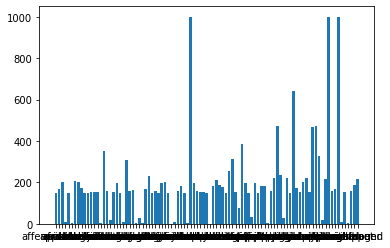

In [37]:
plt.bar(dogs["breed"], height=dogs["count"])
plt.show()

In [38]:
dogs = dogs.sort_values("count", ascending=0)

In [39]:
dogs.head(20)

,breed,count
88,terrier,1000
85,spaniel,1000
42,hound,1000
74,retriever,639
81,setter,471
69,poodle,471
80,schnauzer,466
58,mountain,387
15,bulldog,350
82,sheepdog,328


Consider the first k labels(breeds) with most number of images:


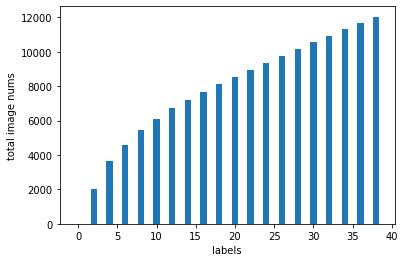

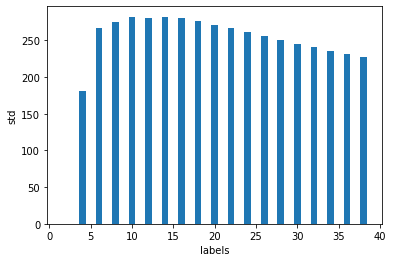

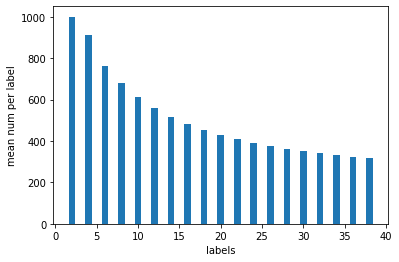

In [40]:
first_x = [*range(0,40,2)]

cummu_sum = [dogs["count"][:x].sum() for x in first_x]
cummu_sd = [dogs["count"][:x].std() for x in first_x]
cummu_mean = [dogs["count"][:x].mean() for x in first_x]

print("Consider the first k labels(breeds) with most number of images:")

fig, ax = plt.subplots()
ax.set_ylabel('total image nums')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sum)


fig, ax = plt.subplots()
ax.set_ylabel('std')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_sd)

fig, ax = plt.subplots()
ax.set_ylabel('mean num per label')
ax.set_xlabel('labels')
plt.bar(first_x, cummu_mean)


plt.show()

## Save downloaded images as pytorch model

In [5]:
%reset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage.io import imread, imshow
from tqdm.notebook import tqdm

from utils import save_dataset

In [6]:
data = pd.read_csv("dog_data.csv")
data.head()
imgs = []
for image_path in tqdm(data["image_name"]):
    img = imread(image_path)
    imgs.append(np.array(img, dtype=np.uint8))

data_x = np.stack(imgs)
data_y = data["label"].values
data_x.shape, data_y.shape

100%|██████████| 5725/5725 [00:04<00:00, 1251.81it/s]


((5725, 224, 224, 3), (5725,))

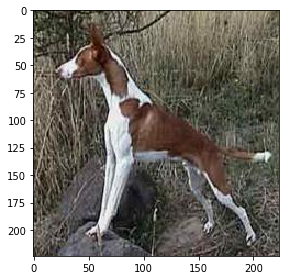

In [7]:
imshow(data_x[np.random.choice(data_x.shape[0])])

### Split data into train and test sets

In [8]:
n = data_x.shape[0]
idx = torch.randperm(n)
train_size = int(n * 0.9)

train_idx = idx[:train_size]
test_idx = idx[train_size:]

train_x = data_x[train_idx]
train_y = data_y[train_idx]
test_x = data_x[test_idx]
test_y = data_y[test_idx]

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((5152, 224, 224, 3), (5152,), (573, 224, 224, 3), (573,))

In [9]:
save_dataset(train_x, train_y, "unaug", "224")
save_dataset(test_x, test_y, "test", "224")

## Downsample dataset

In [1]:
%reset

from skimage.transform import resize
import numpy as np
from tqdm.notebook import tqdm

from utils import load_dataset, save_dataset

In [2]:
train_x, train_y = load_dataset("unaug", "224")
test_x, test_y = load_dataset("test", "224")

In [3]:
w = 64

train_small_imgs = []
for img in tqdm(train_x):
    train_small_imgs.append(img if img.shape[0] == w == img.shape[1] else resize(img, (w, w)))
train_small_x = np.stack(train_small_imgs)
train_small_y = train_y

test_small_imgs = []
for img in tqdm(test_x):
    test_small_imgs.append(img if img.shape[0] == w == img.shape[1] else resize(img, (w, w)))
test_small_x = np.stack(test_small_imgs)
test_small_y = test_y

train_small_x.shape, train_small_y.shape, test_small_x.shape, test_small_y.shape

100%|██████████| 573/573 [00:01<00:00, 296.55it/s]


((5152, 64, 64, 3), (5152,), (573, 64, 64, 3), (573,))

In [4]:
save_dataset(train_small_x, train_small_y, "unaug", f"{w}")
save_dataset(test_small_x, test_small_y, "test", f"{w}")

## Perform image augmentation to downloaded images

Augmentations include rotations, shifting, flipping, adding noise and using cutmix

In [5]:
%reset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.filters import gaussian
from skimage.io import imshow
from skimage.transform import AffineTransform, rescale, resize, rotate, warp
from skimage.util import img_as_ubyte, random_noise
import torch
from tqdm.notebook import tqdm

import random

from utils import load_dataset, save_dataset

In [6]:
unaug_x, unaug_y = load_dataset("unaug", "224")

In [7]:
label, counts = np.unique(unaug_y, return_counts=True)
unaug_y_count = dict(zip(label, counts))
unaug_y_count

{0: 894, 1: 307, 2: 425, 4: 563, 5: 905, 6: 293, 7: 432, 8: 912, 9: 421}

In [8]:
# Ref:
# https://towardsdatascience.com/image-augmentation-with-skimage-python-7f53f1b0eeb5
def get_aug_img(img, multiplier, isRandom=True):
    fs = [
        lambda img: img,
        lambda img: np.fliplr(img),
        lambda img: np.flipud(img),
        lambda img: img_as_ubyte(rotate(img, angle=45, mode='wrap')),
        lambda img: img_as_ubyte(rotate(img, angle=30, mode='wrap')),
        lambda img: img_as_ubyte(random_noise(img, var=0.2**2)),
        lambda img: img_as_ubyte(gaussian(img, sigma=1, channel_axis=True)),
        lambda img: img_as_ubyte(warp(img, AffineTransform(translation=(35, 35)), mode='wrap')),
        lambda img: rescale(img, 1.1)
    ]
    return (
        f(img)
        for f in (random.sample(fs, multiplier) if isRandom else fs[:multiplier])
    )

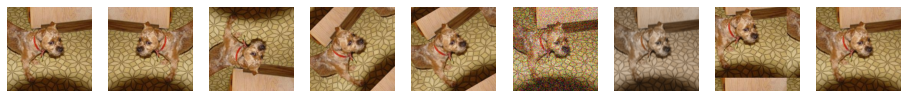

In [9]:
# Test all 9 types of augmentations
fig, ax = plt.subplots(nrows = 1, ncols = 9, figsize = (16, 16))
idx = np.random.choice(unaug_x.shape[0])

for i, aug in enumerate(get_aug_img(img=unaug_x[idx], multiplier=9, isRandom=False)):
    ax[i].imshow(aug)
    ax[i].axis('off')

### Balanced Augmentation (without CutMix)

In [10]:
# balanced augmentation
balan_imgs = []
balan_x = []
balan_y = []

w = 64
n = 2000

for i in tqdm(range(unaug_x.shape[0])):
    img, label = unaug_x[i], unaug_y[i]
    
    # multiplier round to nearest
    aug_multiplier = int(n / unaug_y_count[label] + 0.5)
    for img_aug in get_aug_img(img=img, multiplier=aug_multiplier):
        balan_imgs.append(img_aug if img_aug.shape[0] == w == img_aug.shape[1] else resize(img_aug, (w, w)))
        balan_y.append(label)

balan_x = np.stack(balan_imgs)
balan_y = np.array(balan_y)
balan_x.shape, balan_y.shape

 35%|███▍      | 1789/5152 [00:44<01:24, 39.82it/s]


KeyboardInterrupt: 

In [48]:
# Show the augmented number for each label
labels, counts = np.unique(balan_y, return_counts=True)
balan_y_count = dict(zip(labels, counts))
balan_y_count

{0: 1788,
 1: 2149,
 2: 2125,
 4: 2252,
 5: 1810,
 6: 2051,
 7: 2160,
 8: 1824,
 9: 2105}

In [49]:
save_dataset(balan_x, balan_y, "balan", f"{w}")

### Balanced Augmentation (with ~50% CutMix)

In [50]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [51]:
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return image_batch_updated, label

In [52]:
cut_mix_imgs, cut_mix_labels = generate_cutmix_image(unaug_x, unaug_y, 0.5)

0.4340720663265307

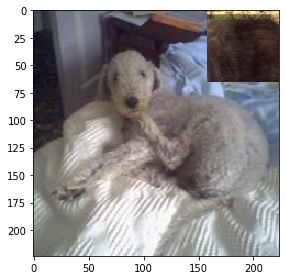

In [53]:
idx = np.random.choice(cut_mix_imgs.shape[0])
imshow(cut_mix_imgs[idx])

cut_mix_labels[idx]

In [54]:
# balanced augmentation
balan_y = list(balan_y)

for i in tqdm(range(cut_mix_imgs.shape[0])):
    img, label = cut_mix_imgs[i], cut_mix_labels[i]
    balan_imgs.append(img if img.shape[0] == w == img.shape[1] else resize(img, (w, w)))
    balan_y.append(label)

balan_x = np.stack(balan_imgs)
balan_y = np.array(balan_y)
balan_x.shape, balan_y.shape

100%|██████████| 5152/5152 [00:16<00:00, 319.94it/s]


((23416, 64, 64, 3), (23416,))

In [55]:
# Show the augmented number for each label
labels, counts = np.unique(balan_y, return_counts=True)
balan_y_count = dict(zip(labels, counts))
balan_y_count

{0.0: 1951,
 0.08681441326530615: 58,
 0.1736288265306123: 73,
 0.3472576530612246: 100,
 0.4340720663265307: 167,
 0.5208864795918369: 58,
 0.607700892857143: 67,
 0.6945153061224492: 147,
 0.7813297193877553: 61,
 0.9131855867346939: 48,
 1.0: 2169,
 1.0868144132653061: 25,
 1.2604432397959184: 38,
 1.3472576530612246: 56,
 1.4340720663265307: 9,
 1.5208864795918369: 27,
 1.607700892857143: 57,
 1.6945153061224492: 27,
 1.8263711734693877: 80,
 1.9131855867346939: 20,
 2.0: 2159,
 2.1736288265306123: 36,
 2.2604432397959187: 70,
 2.3472576530612246: 21,
 2.4340720663265305: 37,
 2.520886479591837: 86,
 2.6077008928571432: 41,
 3.6527423469387754: 94,
 3.7395567602040813: 36,
 3.8263711734693877: 39,
 4.0: 2313,
 4.086814413265306: 91,
 4.173628826530612: 37,
 4.260443239795919: 61,
 4.347257653061225: 102,
 4.4340720663265305: 42,
 4.5659279336734695: 169,
 4.652742346938775: 46,
 4.739556760204081: 85,
 4.913185586734694: 102,
 5.0: 1960,
 5.086814413265307: 56,
 5.173628826530613: 

In [56]:
save_dataset(balan_x, balan_y, "balan_cutmix", f"{w}")